In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from crepes_weighted import WrapRegressor
import copy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def synthetic_kang_schafer_2007(n=2000, weights=None):
    if weights is None:
        weights = np.ones(n)/n
    x1 = np.random.normal(size=n)
    x2 = np.random.normal(size=n)
    x3 = np.random.normal(size=n)
    x4 = np.random.normal(size=n)

    y = 210 + 27.4*x1 + 13.7*x2 + 13.7*x3 + 13.7*x4 + np.random.normal(size=n)

    return np.stack([x1, x2, x3, x4], axis=1), y

def weighted_sample(weights, frac=0.5):
    return np.random.choice(range(len(weights)), size=int(len(weights) * frac), p=weights)



NSim = 1000
confidence = 0.8

for i in tqdm(range(NSim)):
    X, y = synthetic_kang_schafer_2007()
    # Without covariate-shift
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    X_train_prop, X_cal, y_train_prop, y_cal = train_test_split(X_train, y_train, test_size=0.5)

    shift_weights = np.array([-1, 0.5, -0.25, -0.1])
    shifted_likelihood_train_prop = np.exp(X_train_prop @ shift_weights)
    shifted_weights_train_prop = shifted_likelihood_train_prop / np.sum(shifted_likelihood_train_prop)
    shifted_likelihood_test = np.exp(X_test @ shift_weights)
    shifted_weights_test = shifted_likelihood_test / np.sum(shifted_likelihood_test)
    shifted_likelihood_cal =  np.exp(X_cal @ shift_weights)

    rf_cps = WrapRegressor(RandomForestRegressor(n_estimators=100, random_state=17))
    rf_cps.fit(X_train_prop, y_train_prop)
    rf_cp = copy.deepcopy(rf_cps)
    rf_cp.calibrate(X_cal, y_cal, cps=False)
    rf_cps.calibrate(X_cal, y_cal, cps=True)

    idx_no_shift = weighted_sample(np.ones(len(shifted_weights_test))/len(shifted_weights_test), frac=0.25)
    idx_shift = weighted_sample(shifted_weights_test, frac=0.25)

    n_reduced = np.sum(np.abs(shifted_likelihood_cal))**2 / np.sum(shifted_likelihood_cal**2)
    n = len(shifted_likelihood_cal)

    result_cps_no_shift = rf_cps.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                                  confidence=confidence)
    result_cps_shift_not_weighted = rf_cps.evaluate(X_test[idx_shift], y_test[idx_shift],
                                            confidence=confidence)
    result_cp_no_shift = rf_cp.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                                    confidence=confidence)
    result_cp_shift_not_weighted = rf_cp.evaluate(X_test[idx_shift], y_test[idx_shift],
                                              confidence=confidence)

    idx_cal_n_reduced = np.random.choice(range(n), size=int(n_reduced), replace=False)

    rf_cps_shift = copy.deepcopy(rf_cps)
    rf_cps_no_shift_reduced = copy.deepcopy(rf_cps)
    rf_cp_shift = copy.deepcopy(rf_cp)
    rf_cp_no_shift_reduced = copy.deepcopy(rf_cp)


    rf_cps_shift.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=True)
    rf_cp_shift.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=False)

    rf_cps_no_shift_reduced.calibrate(X_cal[idx_cal_n_reduced], y_cal[idx_cal_n_reduced], cps=True)
    rf_cp_no_shift_reduced.calibrate(X_cal[idx_cal_n_reduced], y_cal[idx_cal_n_reduced], cps=False)

    result_cps_shift_weighted = rf_cps_shift.evaluate(X_test[idx_shift], y_test[idx_shift],
                    likelihood_ratios=shifted_likelihood_test[idx_shift], confidence=confidence)
    result_cp_shift_weighted = rf_cp_shift.evaluate(X_test[idx_shift], y_test[idx_shift],
                    likelihood_ratios=shifted_likelihood_test[idx_shift], confidence=confidence)
    result_cps_no_shift_reduced = rf_cps_no_shift_reduced.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                    confidence=confidence)
    result_cp_no_shift_reduced = rf_cp_no_shift_reduced.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                    confidence=confidence)

    result_cps_shift_weighted["reduced_n"] = n_reduced
    result_cp_shift_weighted["reduced_n"] = n_reduced
    result_cps_no_shift_reduced["reduced_n"] = int(n_reduced)
    result_cp_no_shift_reduced["reduced_n"] = int(n_reduced)

    result_cps_no_shift["sim_id"] = i
    result_cps_shift_not_weighted["sim_id"] = i
    result_cps_shift_weighted["sim_id"] = i
    result_cp_no_shift["sim_id"] = i
    result_cp_shift_not_weighted["sim_id"] = i
    result_cp_shift_weighted["sim_id"] = i
    result_cps_no_shift_reduced["sim_id"] = i
    result_cp_no_shift_reduced["sim_id"] = i

    if i == 0:
        df_results_cps_no_shift_syn = pd.DataFrame(result_cps_no_shift, index=[0])
        df_results_cps_shift_not_weighted_syn = pd.DataFrame(result_cps_shift_not_weighted, index=[0])
        df_results_cps_shift_weighted_syn = pd.DataFrame(result_cps_shift_weighted, index=[0])
        df_results_cp_no_shift_syn = pd.DataFrame(result_cp_no_shift, index=[0])
        df_results_cp_shift_not_weighted_syn = pd.DataFrame(result_cp_shift_not_weighted, index=[0])
        df_results_cp_shift_weighted_syn = pd.DataFrame(result_cp_shift_weighted, index=[0])
        df_results_cps_no_shift_reduced_syn = pd.DataFrame(result_cps_no_shift_reduced, index=[0])
        df_results_cp_no_shift_reduced_syn = pd.DataFrame(result_cp_no_shift_reduced, index=[0])
    else:
        df_results_cps_no_shift_syn = pd.concat([df_results_cps_no_shift_syn, pd.DataFrame(result_cps_no_shift, index=[0])])
        df_results_cps_shift_not_weighted_syn = pd.concat([df_results_cps_shift_not_weighted_syn, pd.DataFrame(result_cps_shift_not_weighted, index=[0])])
        df_results_cps_shift_weighted_syn = pd.concat([df_results_cps_shift_weighted_syn, pd.DataFrame(result_cps_shift_weighted, index=[0])])
        df_results_cp_no_shift_syn = pd.concat([df_results_cp_no_shift_syn, pd.DataFrame(result_cp_no_shift, index=[0])])
        df_results_cp_shift_not_weighted_syn = pd.concat([df_results_cp_shift_not_weighted_syn, pd.DataFrame(result_cp_shift_not_weighted, index=[0])])
        df_results_cp_shift_weighted_syn = pd.concat([df_results_cp_shift_weighted_syn, pd.DataFrame(result_cp_shift_weighted, index=[0])])
        df_results_cps_no_shift_reduced_syn = pd.concat([df_results_cps_no_shift_reduced_syn, pd.DataFrame(result_cps_no_shift_reduced, index=[0])])
        df_results_cp_no_shift_reduced_syn = pd.concat([df_results_cp_no_shift_reduced_syn, pd.DataFrame(result_cp_no_shift_reduced, index=[0])])

  0%|          | 4/1000 [00:03<13:55,  1.19it/s]/home/plealm/Documentos/Unal/Maestria/Tesis/code/.venv/lib/python3.10/site-packages/crepes_weighted/base.py:1195: UserWarning: the no. of calibration examples is too small for the following lower percentiles and observation: 
(Perc: 9.999999999999998, Obs: 7, Weight obs: [0.15855595], Smallest density: [0.18830961]) 
(Perc: 9.999999999999998, Obs: 8, Weight obs: [0.08738358], Smallest density: [0.11965391]) 
(Perc: 9.999999999999998, Obs: 10, Weight obs: [0.15855595], Smallest density: [0.18830961]) 
(Perc: 9.999999999999998, Obs: 12, Weight obs: [0.15855595], Smallest density: [0.18830961]) 
(Perc: 9.999999999999998, Obs: 21, Weight obs: [0.15855595], Smallest density: [0.18830961]) 
(Perc: 9.999999999999998, Obs: 25, Weight obs: [0.15855595], Smallest density: [0.18830961]) 
(Perc: 9.999999999999998, Obs: 27, Weight obs: [0.08738358], Smallest density: [0.11965391]) 
(Perc: 9.999999999999998, Obs: 29, Weight obs: [0.15855595], Smallest 

KeyboardInterrupt: 

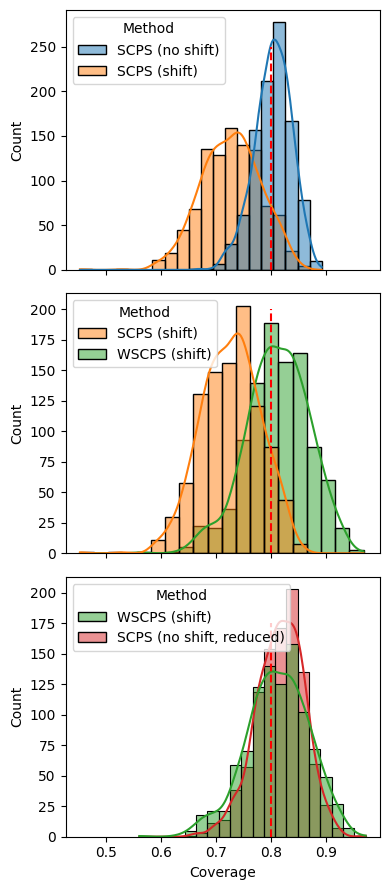

In [ ]:
df_results_cps_no_shift_syn['Method'] = 'SCPS (no shift)'
df_results_cps_shift_not_weighted_syn['Method'] = 'SCPS (shift)'
df_results_cps_shift_weighted_syn['Method'] = 'WSCPS (shift)'
df_results_cps_no_shift_reduced_syn['Method'] = 'SCPS (no shift, reduced)'
df_results_cp_no_shift_syn['Method'] = 'CP (no shift)'
df_results_cp_shift_not_weighted_syn['Method'] = 'CP (shift)'
df_results_cp_shift_weighted_syn['Method'] = 'WCP (shift)'
df_results_cp_no_shift_reduced_syn['Method'] = 'CP (no shift, reduced)'

df_results_syn = pd.concat([df_results_cps_no_shift_syn, df_results_cps_shift_not_weighted_syn, df_results_cps_shift_weighted_syn,
                        df_results_cps_no_shift_reduced_syn,
                        df_results_cp_no_shift_syn, df_results_cp_shift_not_weighted_syn, df_results_cp_shift_weighted_syn,
                        df_results_cp_no_shift_reduced_syn])

df_results_syn["Coverage"] = 1 - df_results_syn["error"]

fig, axs = plt.subplots(3, 1, figsize=(4, 9), sharex=True)
bins = 20
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['SCPS (no shift)',
                                                        'SCPS (shift)'])]
             , x="Coverage", hue="Method", kde=True, ax=axs[0], bins=bins)
sns.move_legend(axs[0], "upper left")
# set the color palette
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (shift)'])]
             , x="Coverage", hue="Method", kde=True, ax=axs[1], bins=bins,
             palette=[sns.color_palette()[1], sns.color_palette()[2]])
sns.move_legend(axs[1], "upper left")
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (no shift, reduced)'])]
                , x="Coverage", hue="Method", kde=True, ax=axs[2], bins=bins,
                palette=[sns.color_palette()[2], sns.color_palette()[3]])
sns.move_legend(axs[2], "upper left")
axs[0].vlines(0.8, 0, 250, color='r', linestyle='--')
axs[1].vlines(0.8, 0, 200, color='r', linestyle='--')
axs[2].vlines(0.8, 0, 175, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Prueba

/home/plealm/Documentos/Unal/Maestria/Tesis/code/.venv/lib/python3.10/site-packages/crepes_weighted/base.py:1195: UserWarning: the no. of calibration examples is too small for the following lower percentiles and observation: 
(Perc: 4.999999999999999, Obs: 0, Weight obs: [0.05], Smallest density: [0.1]); the corresponding values are set to y_min
  warnings.warn(


{'predicted_mean': np.float64(-0.6504663129934023), 'predicted_median': np.float64(0.05), 'prediction_interval_low': np.float64(-inf), 'prediction_interval_high': np.float64(0.503148076951041), 'raw_predictions': array([[-3.61361104,  0.05      ],
       [-2.44209532,  0.05      ],
       [-2.31696552,  0.05      ],
       [-2.09123107,  0.05      ],
       [-1.94703198,  0.05      ],
       [-1.87161389,  0.05      ],
       [-1.79979807,  0.05      ],
       [-1.70285772,  0.05      ],
       [-1.6973183 ,  0.05      ],
       [-1.50236958,  0.05      ],
       [-1.4404273 ,  0.05      ],
       [-1.06150159,  0.05      ],
       [-0.85029128,  0.05      ],
       [-0.79743557,  0.05      ],
       [-0.6806537 ,  0.05      ],
       [-0.38423642,  0.05      ],
       [-0.08020815,  0.05      ],
       [ 0.10877853,  0.05      ],
       [ 0.50314808,  0.05      ]])}


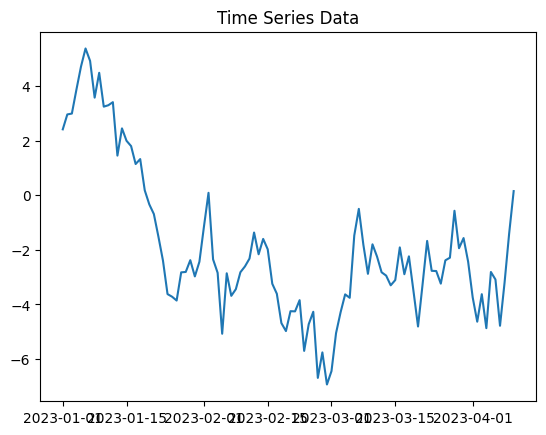

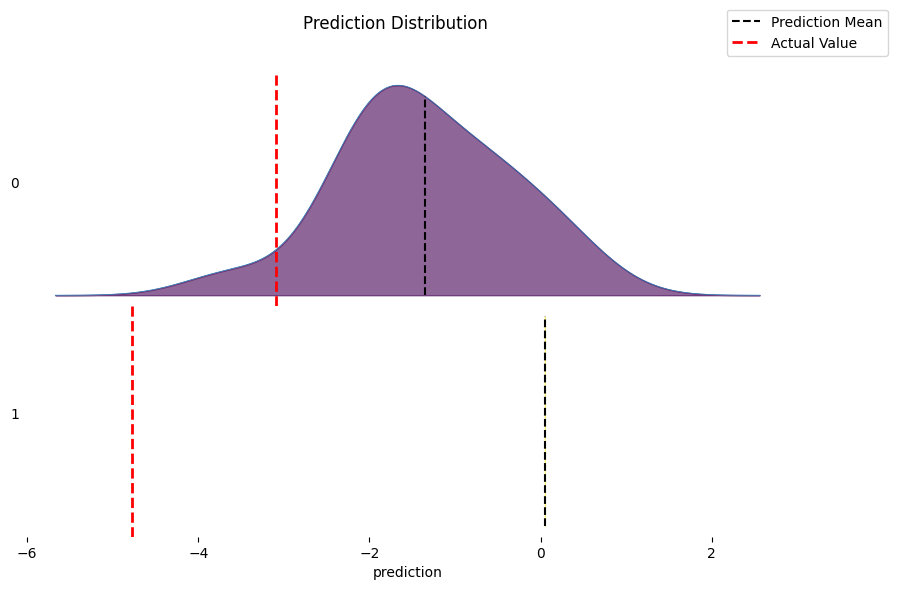

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from crepes_weighted import WrapRegressor
import matplotlib.pyplot as plt
from typing import Optional, Any



def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 test_data: pd.Series,
                                 **fig_kw) -> plt.Figure:
    # If predictions are 1D, convert to a DataFrame with default index
    if bootstrapping_predictions.ndim == 1:
        bootstrapping_predictions = pd.DataFrame(bootstrapping_predictions)

    # Use range of indices instead of assuming existing index
    index = list(range(bootstrapping_predictions.shape[1]))
    palette = plt.cm.viridis(np.linspace(0, 1, len(index)))
    
    # Remove test_data from fig_kw if it's there
    fig_kw.pop('test_data', None)
    
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Create empty lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.iloc[:, step]
            .plot.kde(ax=axs[i], lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i], alpha=0.6)
        
        prediction_mean = bootstrapping_predictions.iloc[:, step].mean()
        idx = np.abs(x - prediction_mean).argmin()
        mean_line = axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='black')
        
        # Plot the real test value in red (if available)
        if test_data is not None and len(test_data) > step:
            real_value = test_data.iloc[step]
            actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
        else:
            actual_line = None
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(str(step), rotation='horizontal')
        axs[i].set_xlabel('prediction')
        
        # Add legend handles and labels only once
        if i == 0:
            legend_handles.extend([mean_line])
            legend_labels.extend(['Prediction Mean'])
            if actual_line is not None:
                legend_handles.append(actual_line)
                legend_labels.append('Actual Value')

    fig.subplots_adjust(hspace=-0)
    model_title = f"Prediction Distribution"
    fig.suptitle(model_title)
    
    # Add a single legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig


def prepare_time_series_data(df, window_size=5):
    """
    Prepare time series data for prediction.
    
    Parameters:
    - df: DataFrame with 'Date' and 'Value' columns
    - window_size: Number of previous steps to use as features
    
    Returns:
    - X: Feature matrix
    - y: Target vector
    """
    # Ensure date column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Create sliding window features
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df['Value'].iloc[i:i+window_size].values)
        y.append(df['Value'].iloc[i+window_size])
    
    return np.array(X), np.array(y)

def predict_next_value_distribution(
    df, 
    confidence=0.9, 
    window_size=5, 
    n_estimators=100, 
    random_state=42
):
    # Prepare data
    X, y = prepare_time_series_data(df, window_size)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Conformal regression model
    rf_cps = WrapRegressor(
        RandomForestRegressor(
            n_estimators=n_estimators, 
            random_state=random_state
        )
    )
    
    # Train and calibrate
    rf_cps.fit(X_train_scaled, y_train)
    rf_cps.calibrate(X_test_scaled, y_test, cps=True)
    
    # Prepare last window for predicting next value
    last_window = df['Value'].iloc[-window_size:].values.reshape(1, -1)
    last_window_scaled = scaler.transform(last_window)
    
    # Predict with confidence interval
    intervals = rf_cps.predict_int(
        last_window_scaled, 
        confidence=confidence
    )
    
    # Get predictions using CPS
    predictions = rf_cps.predict_cps(
        last_window_scaled, 
        return_cpds=True
    )
    
    # Prepare a DataFrame for the plot_prediction_distribution function
    bootstrapping_predictions = pd.DataFrame(predictions[0])
    
    # Call the plot_prediction_distribution function
    plot_prediction_distribution(
        bootstrapping_predictions,
        test_data=df['Value'].iloc[-window_size:],
        figsize=(10, 6)
    )
    
    return {
        'predicted_mean': np.mean(predictions[0]),
        'predicted_median': np.median(predictions[0]),
        'prediction_interval_low': intervals[0,0],
        'prediction_interval_high': intervals[0,1],
        'raw_predictions': predictions[0]
    }
def example_usage():
    """
    Example usage of the prediction function with synthetic time series data
    """
    # Create example data
    dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
    values = np.cumsum(np.random.normal(0, 1, 100))
    df = pd.DataFrame({'Date': dates, 'Value': values})
    # Graph the data
    plt.plot(df['Date'], df['Value'])
    plt.title('Time Series Data')
    # Predict next value
    result = predict_next_value_distribution(df)
    print(result)

# Uncomment to run
example_usage()